<a href="https://colab.research.google.com/github/danielfang001/moe-profiler/blob/main/elbowanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import sys
import torch
import os
import pickle
from collections import defaultdict
import google.colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
!pip install kneed

In [5]:
import argparse
import sys
import torch
import os
import pickle
from collections import defaultdict
import google.colab

# Configuration for datasets
DATASET_CONFIGS = {
    'mmlu': {
        'path': 'cais/mmlu',
        'name': 'all',
        'split': 'test',
        'type': 'mmlu'
    },
    'arc_easy': {
        'path': 'allenai/ai2_arc',
        'name': 'ARC-Easy',
        'split': 'test',
        'type': 'arc'
    },
    'arc_challenge': {
        'path': 'allenai/ai2_arc',
        'name': 'ARC-Challenge',
        'split': 'test',
        'type': 'arc'
    }
}

def load_samples(dataset_key='mmlu', num_samples=5):
    """Generic function to load samples from a configured dataset."""
    if dataset_key not in DATASET_CONFIGS:
        print(f"Dataset key '{dataset_key}' not found in configs.")
        return []

    config = DATASET_CONFIGS[dataset_key]
    print(f"Loading {num_samples} samples from {config['path']} ({config['name']})...")

    try:
        from datasets import load_dataset
    except ImportError:
        print("datasets library not installed. Install with: pip install datasets")
        return []

    try:
        dataset = load_dataset(config['path'], config['name'], split=config['split'])
        indices = torch.randperm(len(dataset))[:num_samples].tolist()
        samples = [dataset[i] for i in indices]

        # Inject 'subject' if missing (useful for ARC, for compatibility with downstream analysis)
        for s in samples:
            if 'subject' not in s:
                s['subject'] = config['name'] # Use dataset subset name as subject

        return samples
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return []

def format_question(sample, dataset_key='mmlu'):
    """Generic function to format questions based on dataset type."""
    config = DATASET_CONFIGS.get(dataset_key, {'type': 'mmlu'}) # Default to mmlu formatting
    ds_type = config['type']

    question = sample['question']

    if ds_type == 'mmlu':
        choices = sample['choices']
        formatted = f"{question}\n"
        for i, choice in enumerate(choices):
            formatted += f"({chr(65 + i)}) {choice}\n"

    elif ds_type == 'arc':
        choices_text = sample['choices']['text']
        choices_label = sample['choices']['label']
        sorted_choices = sorted(zip(choices_label, choices_text))
        formatted = f"{question}\n"
        for label, text in sorted_choices:
            formatted += f"({label}) {text}\n"

    else:
        formatted = question

    return formatted.strip()

def hook_router_logits(model, logits_dict, sample_idx):
    """Attach hooks to all router modules to capture their logits."""
    handles = []

    def create_hook(router_name):
        def hook_fn(module, input, output):
            # output can be logits or (logits, indices) tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            # Convert to CPU and store with sample index
            if logits is not None:
                key = (router_name, sample_idx)
                if key not in logits_dict:
                    logits_dict[key] = []
                logits_dict[key].append(logits.detach().cpu())

        return hook_fn

    # Find all router/gate modules (exclude expert.*.gate_proj which are projection layers)
    for name, module in model.named_modules():
        if ('gate' in name.lower() or 'router' in name.lower()) and 'gate_proj' not in name.lower():
            hook = module.register_forward_hook(create_hook(name))
            handles.append(hook)

    return handles

def run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                       dataset_key="mmlu",
                       num_samples=5,
                       output_file="router_logits.pkl"):
    """Load model, sample dataset, capture router logits."""

    print(f"Loading model {model_name}...")
    try:
        from transformers import AutoModelForCausalLM, AutoTokenizer
    except ImportError:
        print("transformers library not installed")
        return

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()

    # Load samples
    samples = load_samples(dataset_key, num_samples=num_samples)

    if not samples:
        print("Failed to load samples")
        return

    print(f"Loaded {len(samples)} samples\n")

    # Setup logits collection: key = (router_name, sample_idx), value = list of logit tensors
    logits_dict = defaultdict(list)

    try:
        # Process each sample
        with torch.no_grad():
            for sample_idx, sample in enumerate(samples):
                print(f"Processing sample {sample_idx+1}/{len(samples)}...")

                question_text = format_question(sample, dataset_key)
                print(f"  Question: {question_text[:100]}...")

                # Attach hooks for this sample
                handles = hook_router_logits(model, logits_dict, sample_idx)

                # Tokenize and run forward pass
                inputs = tokenizer(question_text, return_tensors='pt', truncation=True, max_length=512)
                inputs = {k: v.to(model.device) for k, v in inputs.items()}

                # Forward pass (collect logits via hooks)
                _ = model(**inputs, output_hidden_states=False)

                # Remove hooks for this sample
                for handle in handles:
                    handle.remove()

                print(f"  Captured {len([k for k in logits_dict.keys() if k[1] == sample_idx])} routers")

    finally:
        print("\nHooks removed")

    # Reorganize: convert from (router_name, sample_idx) keys to per-sample dicts
    # Structure: {sample_idx: {router_name: logits_tensor}}
    organized_logits = defaultdict(dict)

    for (router_name, sample_idx), logits_list in logits_dict.items():
        # Concatenate all logits from this router on this sample
        try:
            stacked = torch.cat(logits_list, dim=0)
            organized_logits[sample_idx][router_name] = stacked
        except Exception as e:
            # If concatenation fails, keep as list
            organized_logits[sample_idx][router_name] = logits_list

    # Print summary
    print("\nLogits captured per sample:")
    for sample_idx in sorted(organized_logits.keys()):
        print(f"\nSample {sample_idx}:")
        for router_name, logits in organized_logits[sample_idx].items():
            if isinstance(logits, torch.Tensor):
                print(f"  {router_name}: shape {logits.shape}")
            else:
                print(f"  {router_name}: {len(logits)} sequences (variable shapes)")

    # Save to file
    print(f"\nSaving logits to {output_file}...")
    save_data = {
        'model_name': model_name,
        'num_samples': len(samples),
        'samples': samples,  # Keep original samples for reference
        'router_logits': dict(organized_logits),  # Convert defaultdict to dict
        'dataset_key': dataset_key
    }

    with open(output_file, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"Saved! File size: {os.path.getsize(output_file) / 1024 / 1024:.2f} MB")

In [ ]:
run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                    dataset_key="mmlu",
                    num_samples=1000,
                    output_file="mmlu_router_logits.pkl")
run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                    dataset_key="arc_easy",
                    num_samples=500,
                    output_file="arceasy_router_logits.pkl")
run_logits_capture(model_name="allenai/OLMoE-1B-7B-0924-Instruct",
                    dataset_key="arc_challenge",
                    num_samples=500,
                    output_file="arcchallenge_router_logits.pkl")

In [14]:
with open('/content/drive/MyDrive/mmlu_router_logits.pkl', 'rb') as f:
    mmlu = pickle.load(f)

with open('/content/drive/MyDrive/arceasy_router_logits.pkl', 'rb') as f:
    arceasy = pickle.load(f)

with open('/content/drive/MyDrive/arceasy_router_logits.pkl', 'rb') as f:
    arcchallenge = pickle.load(f)

In [15]:
import numpy as np

all_logits_by_layer = {}

for layer in range(16):
    all_logits = []
    for sample in range(mmlu['num_samples']):
        logits = mmlu['router_logits'][sample]
        # Ensure the router name matches the keys stored in your data
        router_name = f'model.layers.{layer}.mlp.gate'
        if router_name in logits:
            probs = torch.softmax(logits[router_name], dim=-1)
            # We sort descending to get the highest probabilities first
            probs, _ = torch.sort(probs, descending=True, dim=-1)
            all_logits.append(probs.float().cpu().numpy()) # Convert to numpy on CPU for vstack
        else:
            print(f"Warning: Router {router_name} not found for sample {sample}")

    if all_logits:
        all_logits_by_layer[layer] = np.vstack(all_logits)
    else:
        print(f"No logits processed for layer {layer}.")

print(f"\nAll logits by layer are stored in the 'all_logits_by_layer' dictionary, containing data for {len(all_logits_by_layer)} layers.")


All logits by layer are stored in the 'all_logits_by_layer' dictionary, containing data for 16 layers.


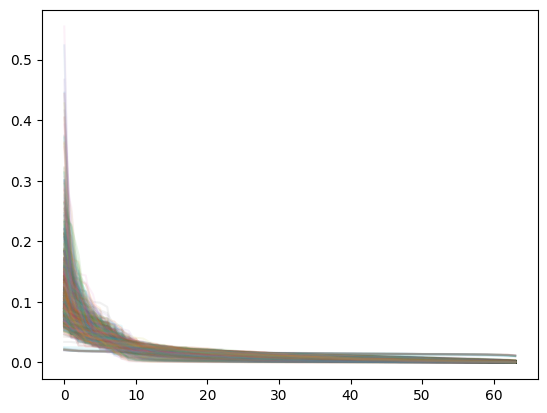

In [16]:
import matplotlib.pyplot as plt
for i in range(16):
  for logits in all_logits[i]:
      plt.plot(logits, alpha=0.1)

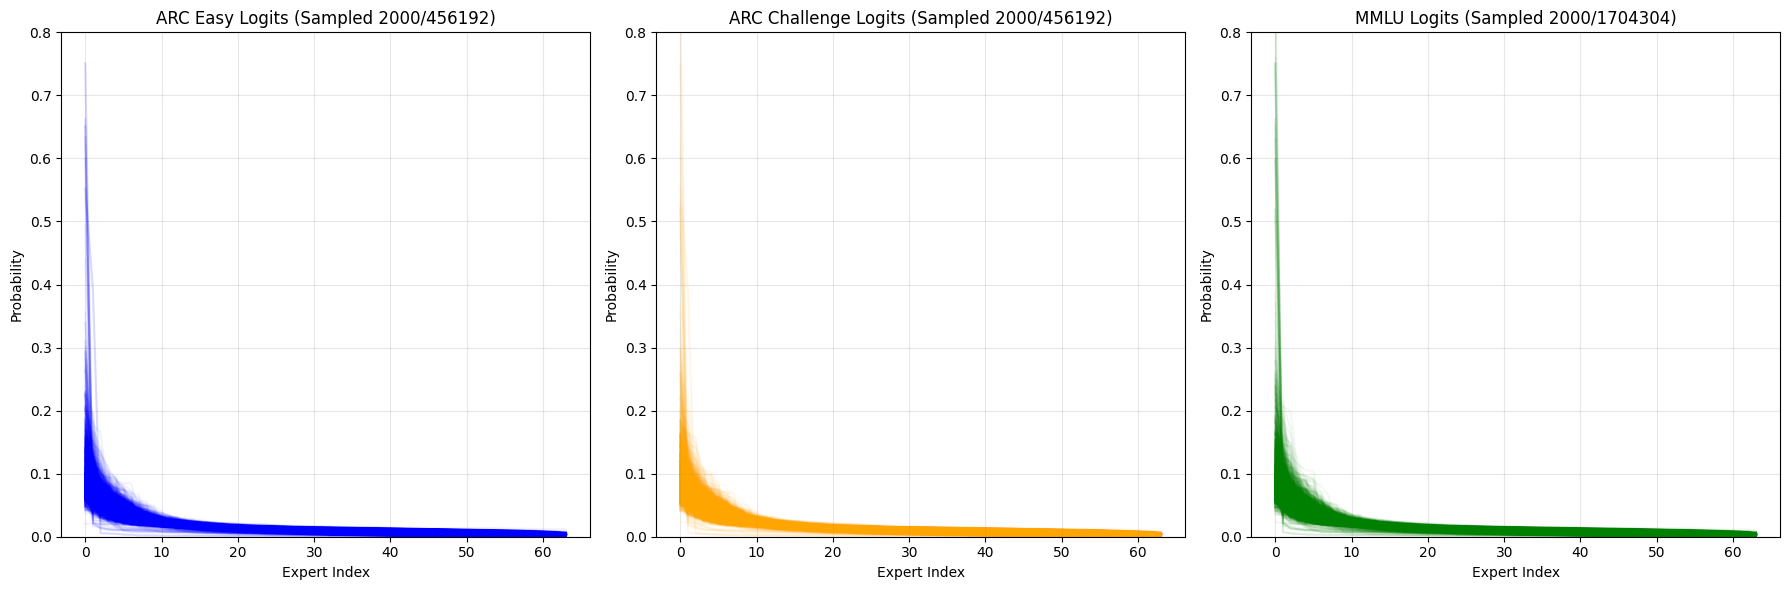

In [22]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

def get_all_sorted_logits(dataset_data):
    all_logits = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for sample_idx, routers in dataset_data['router_logits'].items():
        for logits in routers.values():
            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits)

            # Ensure on correct device
            if device == 'cuda':
                logits = logits.to(device)

            # Softmax & Sort
            probs = torch.softmax(logits.float(), dim=-1)
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)

            # Move to CPU numpy
            all_logits.extend(sorted_probs.cpu().numpy())

    return all_logits

#get data
arceasy_logits = get_all_sorted_logits(arceasy)
arcchallenge_logits = get_all_sorted_logits(arcchallenge)
mmlulogits = get_all_sorted_logits(mmlu)

# Plot
plt.figure(figsize=(18, 6))

# ARC Easy
plt.subplot(1, 3, 1)
sample_easy = random.sample(arceasy_logits, min(len(arceasy_logits), 2000))
for l in sample_easy:
    plt.plot(l, color='blue', alpha=0.05)
plt.title(f'ARC Easy Logits (Sampled 2000/{len(arceasy_logits)})')
plt.xlabel('Expert Index')
plt.ylabel('Probability')
plt.ylim(0, 0.8)
plt.grid(True, alpha=0.3)

# ARC Challenge
plt.subplot(1, 3, 2)
sample_chal = random.sample(arcchallenge_logits, min(len(arcchallenge_logits), 2000))
for l in sample_chal:
    plt.plot(l, color='orange', alpha=0.05)
plt.title(f'ARC Challenge Logits (Sampled 2000/{len(arcchallenge_logits)})')
plt.xlabel('Expert Index')
plt.ylabel('Probability')
plt.ylim(0, 0.8)
plt.grid(True, alpha=0.3)

# MMLU
plt.subplot(1, 3, 3)
sample_mmlu = random.sample(mmlulogits, min(len(mmlulogits), 2000))
for l in sample_mmlu:
    plt.plot(l, color='green', alpha=0.05)
plt.title(f'MMLU Logits (Sampled 2000/{len(mmlulogits)})')
plt.xlabel('Expert Index')
plt.ylabel('Probability')
plt.ylim(0, 0.8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
# Pre-compute x once outside the function
from kneed import KneeLocator
x = range(64)

def calculate_elbow_kneedle(y):
  kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing', online=True)
  k = int(kneedle.elbow) + 1
  return k

x_norm = np.linspace(0, 1, 64)
def calculate_geometric_elbow(y):
    y_range = y[0] - y[-1]
    y_normalized = (y[0] - y) / y_range
    diff = y_normalized - x_norm
    return int(np.argmax(diff))

def elbow_angle(y, elbowidx):
    if elbowidx == 0 or elbowidx == len(y) - 1: return 180.0
    y_np = y if isinstance(y, np.ndarray) else y.cpu().numpy()
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 180.0
    y_norm = (y_np[0] - y_np) / y_range

    pe = np.array([x_norm[elbowidx], y_norm[elbowidx]])
    ps = np.array([0.0, 0.0])
    pend = np.array([1.0, 1.0])
    v1 = ps - pe
    v2 = pend - pe
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

Sampling 5000 logits and calculating elbow angle...


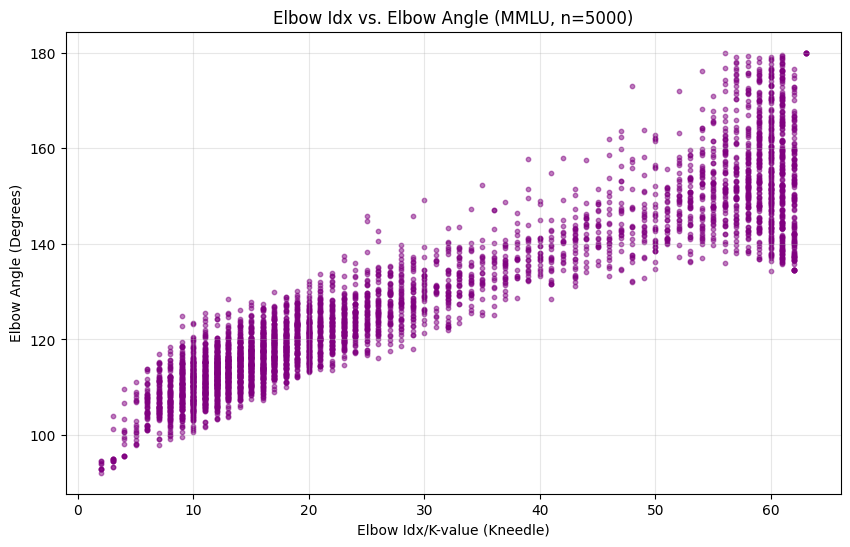

In [56]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np

num_samples = 5000

print(f"Sampling {num_samples} logits and calculating elbow angle...")

elbow_indices = []
angles = []

for _ in range(num_samples):
    i = random.randint(0, len(mmlulogits))

    # Get data
    y = mmlulogits[i]

    # Calculate Index
    idx = calculate_elbow_kneedle(y)

    # Calculate Angle
    ang = elbow_angle(y, idx)

    elbow_indices.append(idx)
    angles.append(ang)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(elbow_indices, angles, alpha=0.5, s=10, color='purple')
plt.title(f'Elbow Idx vs. Elbow Angle (MMLU, n={num_samples})')
plt.xlabel('Elbow Idx/K-value (Kneedle)')
plt.ylabel('Elbow Angle (Degrees)')
plt.grid(True, alpha=0.3)
plt.show()

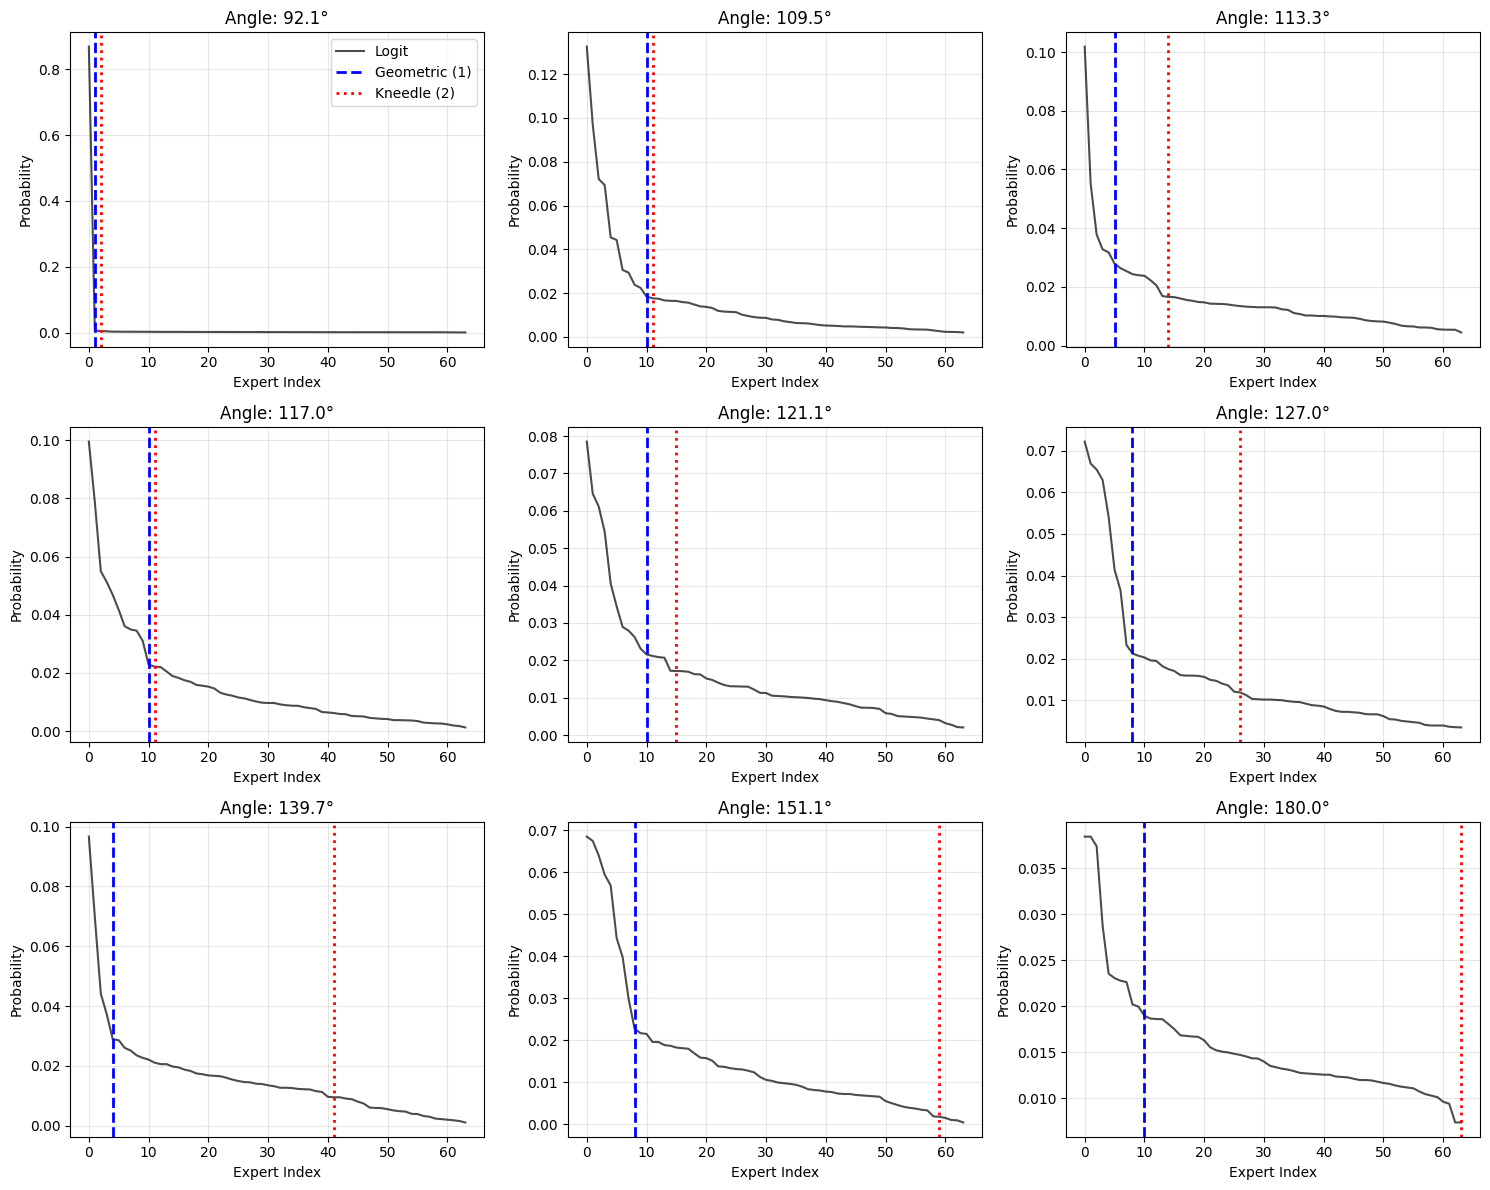

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from kneed import KneeLocator

# 2. Prepare Data Source

data_pool = mmlulogits

# 3. Sample Logits with Varying Angles
if data_pool:
    # Sample a subset to compute angles for sorting
    subset_size = min(2000, len(data_pool))
    subset = random.sample(list(data_pool), subset_size)

    analyzed_samples = []
    for logit in subset:
        # Calculate Geometric Elbow to establish the angle
        kneed_idx = calculate_elbow_kneedle(logit)
        angle = elbow_angle(logit, kneed_idx)
        analyzed_samples.append((angle, logit))

    # Sort by angle to get a range from sharp (low angle) to flat (high angle)
    analyzed_samples.sort(key=lambda x: x[0])

    # Select 9 samples evenly spaced across the sorted list
    indices_to_pick = np.linspace(0, len(analyzed_samples)-1, 9, dtype=int)
    selected_samples = [analyzed_samples[i] for i in indices_to_pick]

    # 4. Plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    for i, (angle, logit) in enumerate(selected_samples):
        ax = axes[i]

        # Calculate both indices
        geom_idx = calculate_geometric_elbow(logit)
        kneed_idx = calculate_elbow_kneedle(logit)

        # Plot Logit
        ax.plot(logit, label='Logit', color='black', alpha=0.7, linewidth=1.5)

        # Plot Vertical Lines
        ax.axvline(geom_idx, color='blue', linestyle='--', linewidth=2, label=f'Geometric ({geom_idx})')
        ax.axvline(kneed_idx, color='red', linestyle=':', linewidth=2, label=f'Kneedle ({kneed_idx})')

        ax.set_title(f"Angle: {angle:.1f}°")
        ax.set_xlabel("Expert Index")
        ax.set_ylabel("Probability")

        # Add legend only to the first plot to avoid clutter
        if i == 0:
            ax.legend(loc='upper right')

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Sampling 5000 logits and calculating elbow indices...


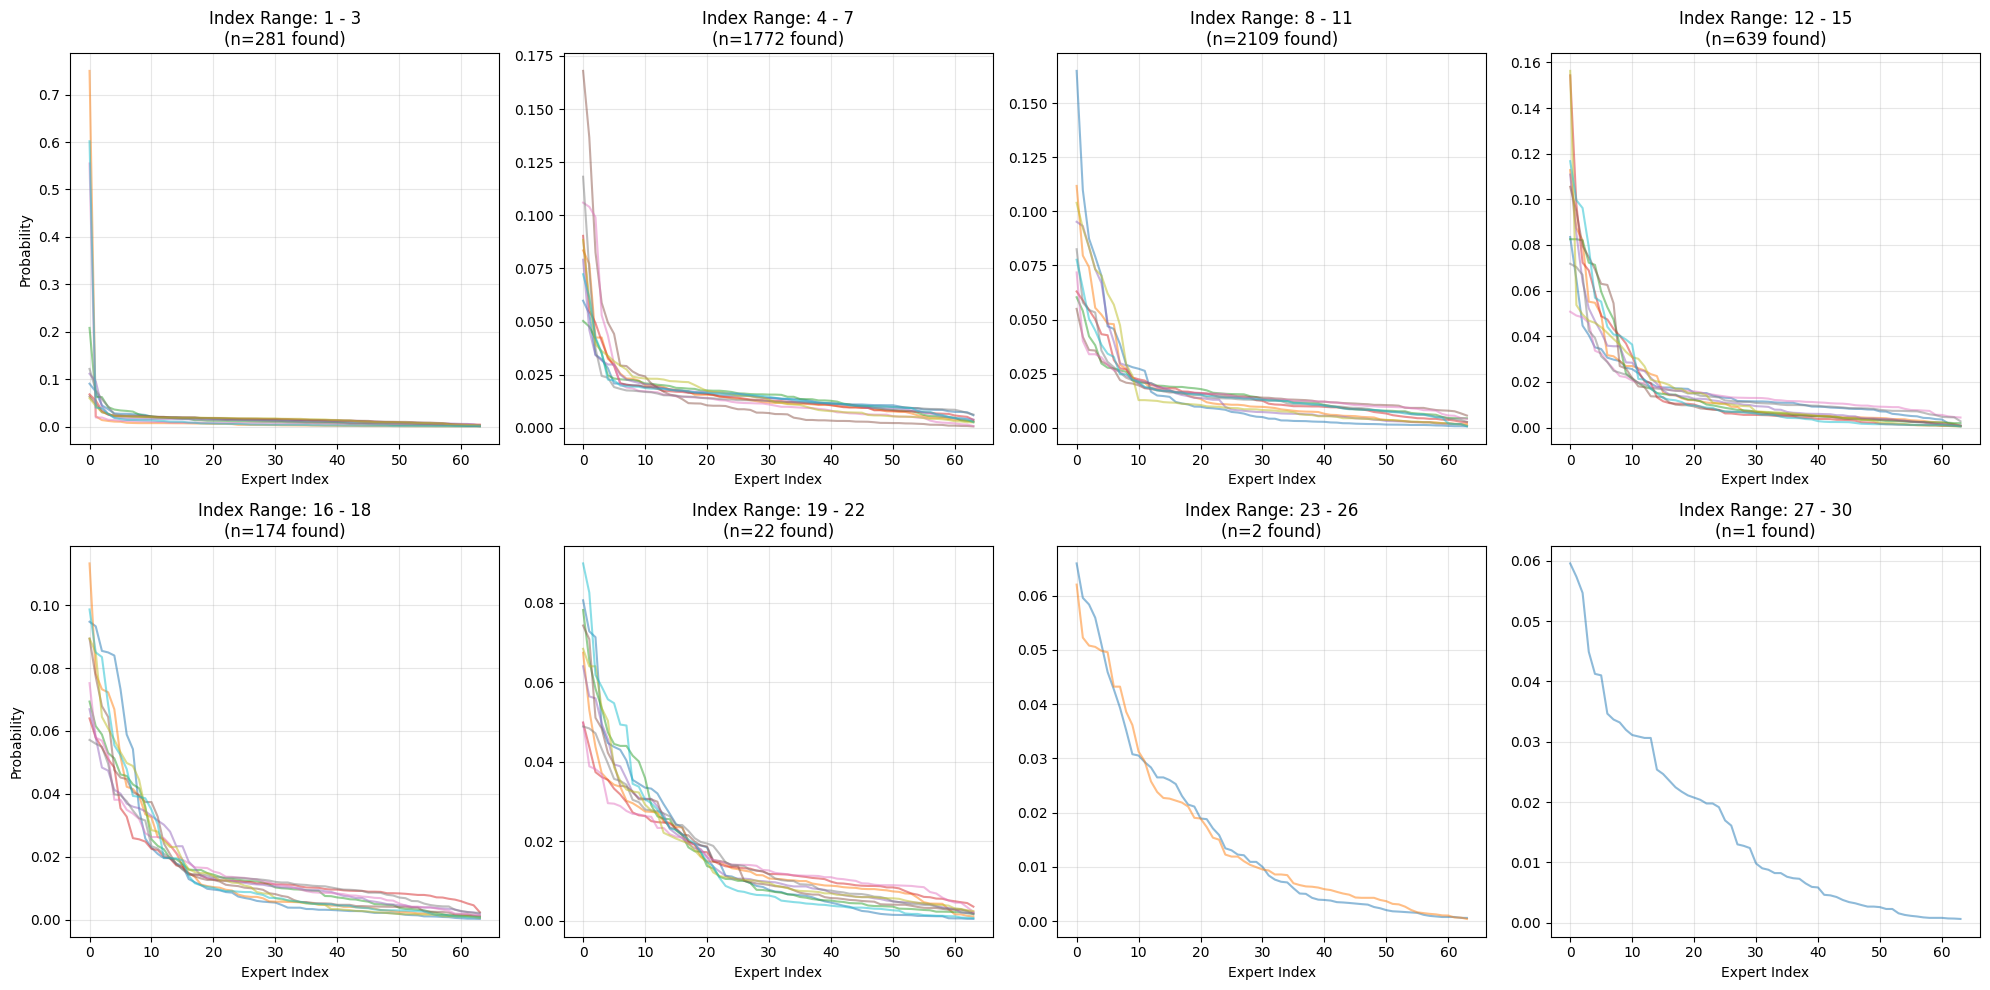

In [59]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np

# Helper function for geometric elbow index
def calculate_original_elbow_local(y_tensor):
    y = y_tensor.cpu().numpy()
    if len(y) < 2: return 0
    x_norm = np.linspace(0, 1, len(y))
    y_range = y[0] - y[-1]
    if y_range == 0: return 0
    y_normalized = (y[0] - y) / y_range
    diff = y_normalized - x_norm
    return int(np.argmax(diff))

# Sample logits
num_search_samples = 5000
layers = list(all_logits_by_layer.keys())
total_rows_per_layer = all_logits_by_layer[layers[0]].shape[0]

sampled_logits_info = []

print(f"Sampling {num_search_samples} logits and calculating elbow indices...")
for _ in range(num_search_samples):
    layer = random.choice(layers)
    row_idx = random.randint(0, total_rows_per_layer - 1)
    y_np = all_logits_by_layer[layer][row_idx]
    y_tensor = torch.from_numpy(y_np).float()

    idx = calculate_original_elbow_local(y_tensor)
    sampled_logits_info.append((idx, y_np))

# Determine range and create 8 bins for Indices
indices = [x[0] for x in sampled_logits_info]
min_idx, max_idx = min(indices), max(indices)

# Create bin edges (using linspace to divide the range into 8 intervals)
bin_edges = np.linspace(min_idx, max_idx + 1, 9)
bins = []
for i in range(8):
    bins.append((bin_edges[i], bin_edges[i+1]))

bin_data = {i: [] for i in range(8)}

# Populate bins
for idx, y_np in sampled_logits_info:
    for i, (low, high) in enumerate(bins):
        # Use < high for all except the last bin which includes the max
        if i == 7:
            if low <= idx <= high:
                bin_data[i].append(y_np)
                break
        else:
            if low <= idx < high:
                bin_data[i].append(y_np)
                break

# Create 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (low, high) in enumerate(bins):
    ax = axes[i]
    logits_list = bin_data[i]

    # Format title based on integer range
    if i == 7:
        title_range = f"{int(low)} - {int(high-1)}"
    else:
        title_range = f"{int(low)} - {int(high-1)}"

    ax.set_title(f"Index Range: {title_range}\n(n={len(logits_list)} found)")
    ax.set_xlabel("Expert Index")
    if i % 4 == 0:
        ax.set_ylabel("Probability")

    if logits_list:
        samples_to_plot = random.sample(logits_list, min(len(logits_list), 10))
        for logits in samples_to_plot:
            ax.plot(logits, alpha=0.5)
    else:
        ax.text(0.5, 0.5, "No samples found", ha='center', va='center')

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [63]:
from collections import Counter

# 1. Re-build the Row-to-Sample Mapping locally
row_to_sample_map = []
num_samples = data['num_samples']
layer_0_name = 'model.layers.0.mlp.gate'

for sample_idx in range(num_samples):
    logits_dict = data['router_logits'][sample_idx]
    if layer_0_name in logits_dict:
        n_rows = logits_dict[layer_0_name].shape[0]
        row_to_sample_map.extend([sample_idx] * n_rows)
    else:
        keys = list(logits_dict.keys())
        if keys:
            n_rows = logits_dict[keys[0]].shape[0]
            row_to_sample_map.extend([sample_idx] * n_rows)

# 2. Aggregate Counts
print("Counting subjects across all logits and subsets...")
total_subj_counts = Counter()
low_elbow_subj_counts = Counter()
high_elbow_subj_counts = Counter()

total_logits_count = 0
low_elbow_total_count = 0
high_elbow_total_count = 0

for layer_idx, results in elbow_results_by_layer.items():
    elbow_indices = results['idx_values']

    for row_idx, elbow_idx in enumerate(elbow_indices):
        if row_idx < len(row_to_sample_map):
            sample_idx = row_to_sample_map[row_idx]
            subj = data['samples'][sample_idx]['subject']

            total_subj_counts[subj] += 1
            total_logits_count += 1

            if elbow_idx < 5:
                low_elbow_subj_counts[subj] += 1
                low_elbow_total_count += 1
            elif elbow_idx > 15:
                high_elbow_subj_counts[subj] += 1
                high_elbow_total_count += 1

# 3. Calculate Differences in Proportions
def calculate_diffs(subset_counts, subset_total):
    diffs = {}
    for subj in total_subj_counts:
        prop_total = total_subj_counts[subj] / total_logits_count
        prop_subset = subset_counts.get(subj, 0) / subset_total if subset_total > 0 else 0
        diffs[subj] = prop_subset - prop_total
    return diffs

low_elbow_diffs = calculate_diffs(low_elbow_subj_counts, low_elbow_total_count)
high_elbow_diffs = calculate_diffs(high_elbow_subj_counts, high_elbow_total_count)

# 4. Helper to print results
def print_top_diffs(diffs, title):
    sorted_diffs = sorted(diffs.items(), key=lambda x: x[1], reverse=True)
    print(f"\n--- {title} ---")
    print("  Over-represented (Subject: Difference)")
    for subj, diff in sorted_diffs[:5]:
        print(f"    {subj}: +{diff:.2%}")
    print("  Under-represented (Subject: Difference)")
    for subj, diff in sorted_diffs[-5:]:
        print(f"    {subj}: {diff:.2%}")

print_top_diffs(low_elbow_diffs, "Elbow Index < 5 (High Confidence)")
print_top_diffs(high_elbow_diffs, "Elbow Index > 15 (Low Confidence)")

Counting subjects across all logits and subsets...

--- Elbow Index < 5 (High Confidence) ---
  Over-represented (Subject: Difference)
    moral_scenarios: +0.36%
    miscellaneous: +0.28%
    moral_disputes: +0.23%
    professional_accounting: +0.16%
    professional_psychology: +0.15%
  Under-represented (Subject: Difference)
    professional_medicine: -0.16%
    professional_law: -0.19%
    college_computer_science: -0.30%
    high_school_us_history: -0.37%
    high_school_world_history: -0.59%

--- Elbow Index > 15 (Low Confidence) ---
  Over-represented (Subject: Difference)
    moral_scenarios: +3.15%
    professional_psychology: +0.43%
    moral_disputes: +0.40%
    high_school_macroeconomics: +0.39%
    college_computer_science: +0.31%
  Under-represented (Subject: Difference)
    high_school_world_history: -0.30%
    security_studies: -0.63%
    professional_medicine: -0.63%
    high_school_us_history: -0.83%
    professional_law: -4.12%


In [69]:
import numpy as np
import torch
from collections import Counter

# 1. Helper Functions (defined locally for safety)
def calculate_original_elbow_local(y_tensor):
    y = y_tensor.cpu().numpy()
    if len(y) < 2: return 0
    x_norm = np.linspace(0, 1, len(y))
    y_range = y[0] - y[-1]
    if y_range == 0: return 0
    y_normalized = (y[0] - y) / y_range
    diff = y_normalized - x_norm
    return int(np.argmax(diff))

def elbow_angle(y, elbowidx):
    if elbowidx == 0 or elbowidx == len(y) - 1: return 180.0
    y_np = y if isinstance(y, np.ndarray) else y.cpu().numpy()
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 180.0
    y_norm = (y_np[0] - y_np) / y_range

    pe = np.array([x_norm[elbowidx], y_norm[elbowidx]])
    ps = np.array([0.0, 0.0])
    pend = np.array([1.0, 1.0])
    v1 = ps - pe
    v2 = pend - pe
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

# 2. Re-build Row-to-Sample Mapping (if not already valid)
row_to_sample_map = []
num_samples = data['num_samples']
layer_0_name = 'model.layers.0.mlp.gate'
for sample_idx in range(num_samples):
    logits_dict = data['router_logits'][sample_idx]
    if layer_0_name in logits_dict:
        n_rows = logits_dict[layer_0_name].shape[0]
        row_to_sample_map.extend([sample_idx] * n_rows)
    else:
        keys = list(logits_dict.keys())
        if keys:
            n_rows = logits_dict[keys[0]].shape[0]
            row_to_sample_map.extend([sample_idx] * n_rows)

# 3. Iterate and Classify based on Angle
print("Calculating angles and counting subjects (this may take a moment)...")
total_subj_counts = Counter()
low_angle_subj_counts = Counter()   # Angle < 110
high_angle_subj_counts = Counter()  # Angle > 140

total_logits_count = 0
low_angle_total = 0
high_angle_total = 0

for layer_idx, logits_array in all_logits_by_layer.items():
    for row_idx, row in enumerate(logits_array):
        if row_idx < len(row_to_sample_map):
            # Calculate stats
            y_tensor = torch.from_numpy(row).float()
            idx = calculate_original_elbow_local(y_tensor)
            angle = elbow_angle(row, idx)

            # Get subject
            sample_idx = row_to_sample_map[row_idx]
            subj = data['samples'][sample_idx]['subject']

            # Update Global Counts
            total_subj_counts[subj] += 1
            total_logits_count += 1

            # Check Categories
            if angle < 100:
                low_angle_subj_counts[subj] += 1
                low_angle_total += 1
            elif angle > 140:
                high_angle_subj_counts[subj] += 1
                high_angle_total += 1

# 4. Calculate & Print Differences
def calculate_diffs(subset_counts, subset_total):
    diffs = {}
    for subj in total_subj_counts:
        prop_total = total_subj_counts[subj] / total_logits_count
        prop_subset = subset_counts.get(subj, 0) / subset_total if subset_total > 0 else 0
        diffs[subj] = prop_subset - prop_total
    return diffs

low_angle_diffs = calculate_diffs(low_angle_subj_counts, low_angle_total)
high_angle_diffs = calculate_diffs(high_angle_subj_counts, high_angle_total)

def print_top_diffs(diffs, title, count):
    sorted_diffs = sorted(diffs.items(), key=lambda x: x[1], reverse=True)
    print(f"\n--- {title} (Total Count: {count}) ---")
    print("  Over-represented:")
    for subj, diff in sorted_diffs[:5]:
        print(f"    {subj}: +{diff:.2%}")
    print("  Under-represented:")
    for subj, diff in sorted_diffs[-5:]:
        print(f"    {subj}: {diff:.2%}")

print_top_diffs(low_angle_diffs, "Elbow Angle < 105 (Sharp/Confident)", low_angle_total)
print_top_diffs(high_angle_diffs, "Elbow Angle > 140 (Flat/Uncertain)", high_angle_total)

Calculating angles and counting subjects (this may take a moment)...

--- Elbow Angle < 105 (Sharp/Confident) (Total Count: 17183) ---
  Over-represented:
    miscellaneous: +2.40%
    world_religions: +0.65%
    clinical_knowledge: +0.65%
    professional_psychology: +0.64%
    prehistory: +0.64%
  Under-represented:
    security_studies: -0.81%
    moral_scenarios: -0.90%
    high_school_world_history: -1.07%
    high_school_us_history: -1.32%
    professional_law: -9.90%

--- Elbow Angle > 140 (Flat/Uncertain) (Total Count: 4799) ---
  Over-represented:
    moral_scenarios: +12.02%
    high_school_macroeconomics: +1.17%
    formal_logic: +0.97%
    moral_disputes: +0.46%
    professional_psychology: +0.35%
  Under-represented:
    security_studies: -0.97%
    professional_law: -1.13%
    high_school_european_history: -1.37%
    high_school_world_history: -2.23%
    high_school_us_history: -2.40%


Aggregating data for scatter plot...


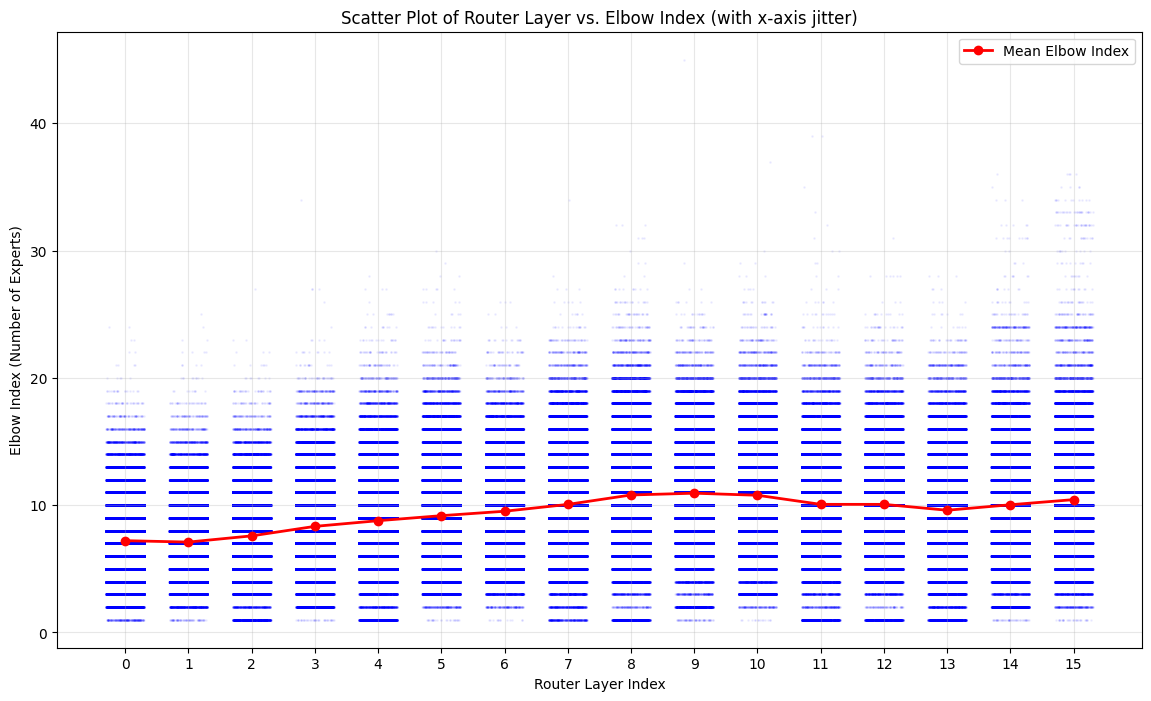

In [70]:
import matplotlib.pyplot as plt
import numpy as np

layers_x = []
elbow_idxs_y = []

print("Aggregating data for scatter plot...")

for layer_idx, results in elbow_results_by_layer.items():
    indices = results['idx_values']

    # Add jitter to x (layer index) for better visualization of density
    # Creating an array of layer_idx with small random noise
    jitter = np.random.uniform(-0.3, 0.3, size=len(indices))
    layers_x.extend(np.array([layer_idx] * len(indices)) + jitter)

    elbow_idxs_y.extend(indices)

plt.figure(figsize=(14, 8))
# Use small marker size (s=1) and low alpha for handling large datasets
plt.scatter(layers_x, elbow_idxs_y, s=1, alpha=0.05, color='blue')

plt.title('Scatter Plot of Router Layer vs. Elbow Index (with x-axis jitter)')
plt.xlabel('Router Layer Index')
plt.ylabel('Elbow Index (Number of Experts)')
plt.xticks(range(16))
plt.grid(True, alpha=0.3)

# Calculate and plot the mean elbow index per layer for reference
mean_indices = []
for layer_idx in range(16):
    indices = elbow_results_by_layer[layer_idx]['idx_values']
    mean_indices.append(np.mean(indices))

plt.plot(range(16), mean_indices, color='red', marker='o', linestyle='-', linewidth=2, label='Mean Elbow Index')
plt.legend()

plt.show()

Calculating angles for all logits (this might take a moment)...


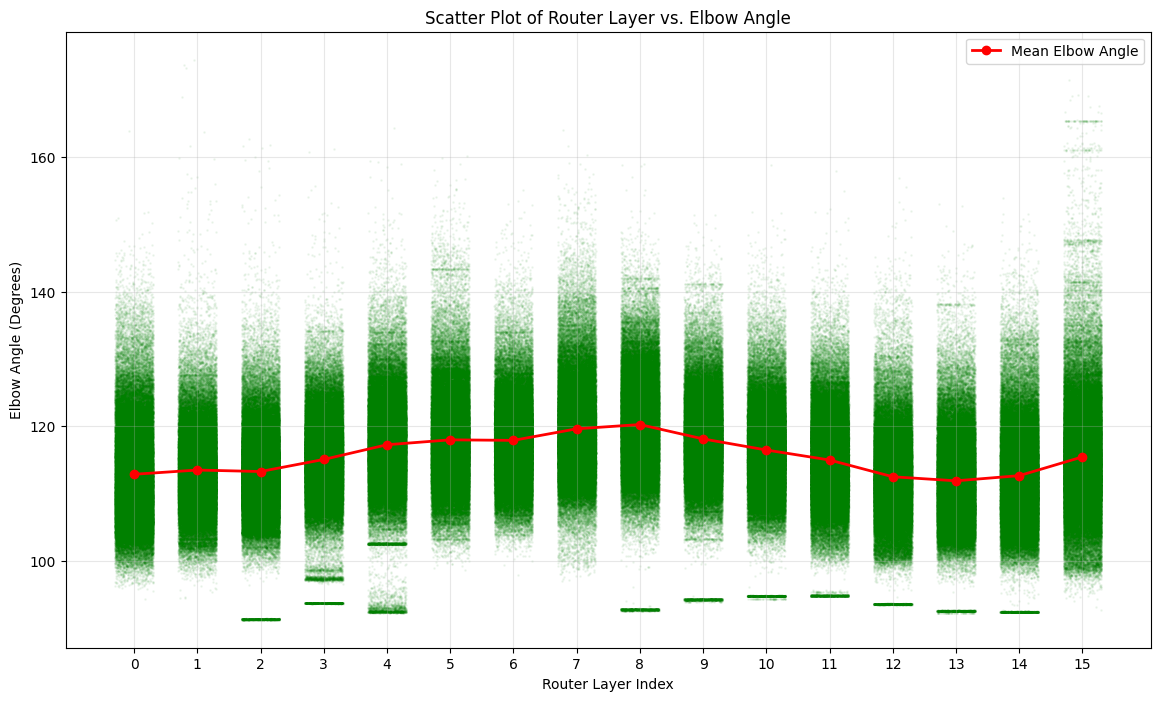

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Helper functions (re-defining to ensure availability in this cell context)
def calculate_original_elbow_local(y_tensor):
    y = y_tensor.cpu().numpy()
    if len(y) < 2: return 0
    x_norm = np.linspace(0, 1, len(y))
    y_range = y[0] - y[-1]
    if y_range == 0: return 0
    y_normalized = (y[0] - y) / y_range
    diff = y_normalized - x_norm
    return int(np.argmax(diff))

def elbow_angle(y, elbowidx):
    if elbowidx == 0 or elbowidx == len(y) - 1: return 180.0
    y_np = y if isinstance(y, np.ndarray) else y.cpu().numpy()
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 180.0
    y_norm = (y_np[0] - y_np) / y_range

    pe = np.array([x_norm[elbowidx], y_norm[elbowidx]])
    ps = np.array([0.0, 0.0])
    pend = np.array([1.0, 1.0])
    v1 = ps - pe
    v2 = pend - pe
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

layers_x = []
angles_y = []
mean_angles = []

print("Calculating angles for all logits (this might take a moment)...")

for layer_idx in sorted(all_logits_by_layer.keys()):
    logits_array = all_logits_by_layer[layer_idx]
    layer_angles = []

    # Add jitter for plotting
    jitter = np.random.uniform(-0.3, 0.3, size=len(logits_array))
    layers_x.extend(np.array([layer_idx] * len(logits_array)) + jitter)

    for row in logits_array:
        y_tensor = torch.from_numpy(row).float()
        idx = calculate_original_elbow_local(y_tensor)
        ang = elbow_angle(row, idx)
        layer_angles.append(ang)

    angles_y.extend(layer_angles)
    mean_angles.append(np.mean(layer_angles))

plt.figure(figsize=(14, 8))
# Use small marker size and low alpha
plt.scatter(layers_x, angles_y, s=1, alpha=0.05, color='green')

plt.title('Scatter Plot of Router Layer vs. Elbow Angle')
plt.xlabel('Router Layer Index')
plt.ylabel('Elbow Angle (Degrees)')
plt.xticks(range(16))
plt.grid(True, alpha=0.3)

# Plot mean
plt.plot(range(16), mean_angles, color='red', marker='o', linestyle='-', linewidth=2, label='Mean Elbow Angle')
plt.legend()

plt.show()

In [67]:
print(total_logits_count)

1704304


Calculating curvature (elbow angle) for all logits...


/tmp/ipython-input-98870453.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = (y[0] - y) / y_range - x_norm


Processed 1704304 total logits.
Found 72036 logits with >15 experts activated.


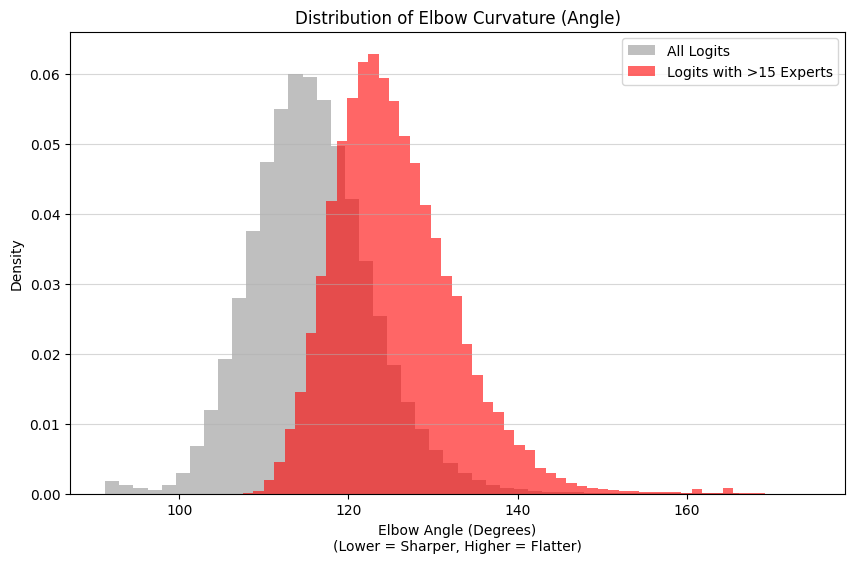

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Collect curvatures (angles)
all_curvatures = []
high_expert_curvatures = []

print("Calculating curvature (elbow angle) for all logits...")

for layer_idx, logits_array in all_logits_by_layer.items():
    for row in logits_array:
        # Convert to tensor for consistency with previous code
        y_tensor = torch.from_numpy(row).float()

        # 1. Find Elbow Index
        idx,dist = calculate_original_elbow(y_tensor)

        # 2. Calculate Curvature (Angle)
        angle = elbow_angle(row, idx)

        all_curvatures.append(angle)

        if idx > 15:
            high_expert_curvatures.append(angle)

print(f"Processed {len(all_curvatures)} total logits.")
print(f"Found {len(high_expert_curvatures)} logits with >15 experts activated.")

# Plot Histograms
plt.figure(figsize=(10, 6))

# Histogram for ALL logits
plt.hist(all_curvatures, bins=50, alpha=0.5, color='gray', label='All Logits', density=True)

# Histogram for logits with >10 experts
plt.hist(high_expert_curvatures, bins=50, alpha=0.6, color='red', label='Logits with >15 Experts', density=True)

plt.title('Distribution of Elbow Curvature (Angle)')
plt.xlabel('Elbow Angle (Degrees)\n(Lower = Sharper, Higher = Flatter)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

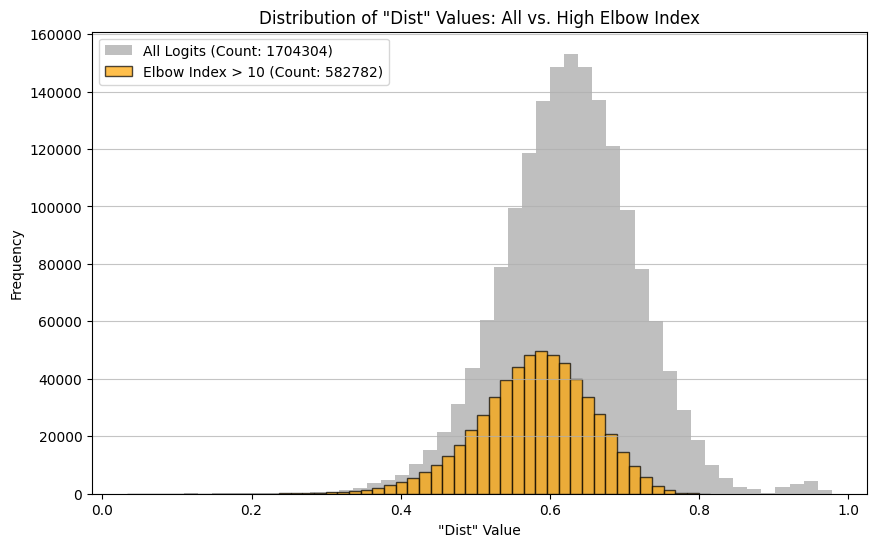

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Collect all dist values
all_dist_values = []
for layer_idx, results in elbow_results_by_layer.items():
    all_dist_values.extend(results['dist_values'])

# 2. Collect dist values where elbow index > 10
high_elbow_dist_values = []
for layer_idx, results in elbow_results_by_layer.items():
    dists = results['dist_values']
    idxs = results['idx_values']

    # Zip and filter
    for d, i in zip(dists, idxs):
        if i > 10:
            high_elbow_dist_values.append(d)

plt.figure(figsize=(10, 6))

# Plot 'All Logits' first so it's in the background
plt.hist(all_dist_values, bins=50, alpha=0.5, label=f'All Logits (Count: {len(all_dist_values)})', color='gray', edgecolor='none')

# Plot the subset on top
plt.hist(high_elbow_dist_values, bins=50, alpha=0.7, label=f'Elbow Index > 10 (Count: {len(high_elbow_dist_values)})', color='orange', edgecolor='black')

plt.title('Distribution of "Dist" Values: All vs. High Elbow Index')
plt.xlabel('"Dist" Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

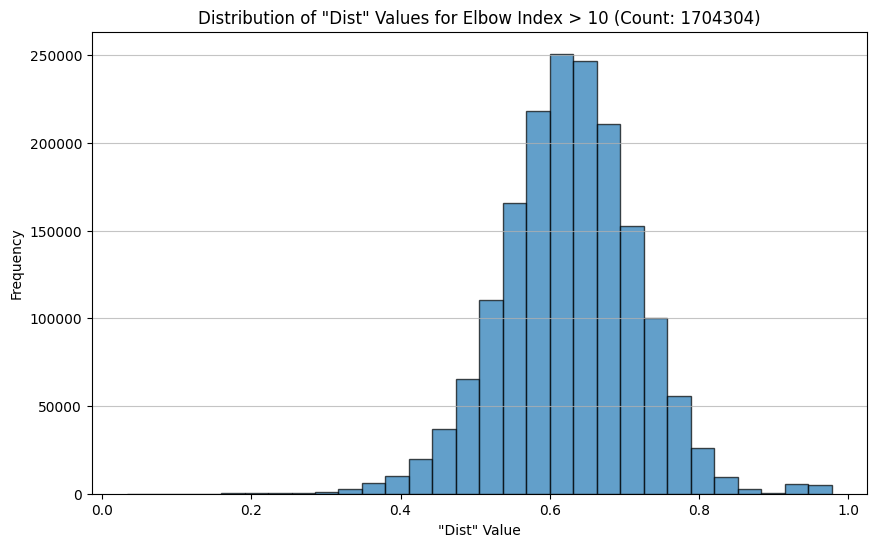

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Collect dist values where elbow index > 10
high_elbow_dist_values = []

for layer_idx, results in elbow_results_by_layer.items():
    dists = results['dist_values']
    idxs = results['idx_values']

    # Zip and filter
    for d, i in zip(dists, idxs):
        high_elbow_dist_values.append(d)

plt.figure(figsize=(10, 6))
plt.hist(high_elbow_dist_values, bins=30, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of "Dist" Values for Elbow Index > 10 (Count: {len(high_elbow_dist_values)})')
plt.xlabel('"Dist" Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

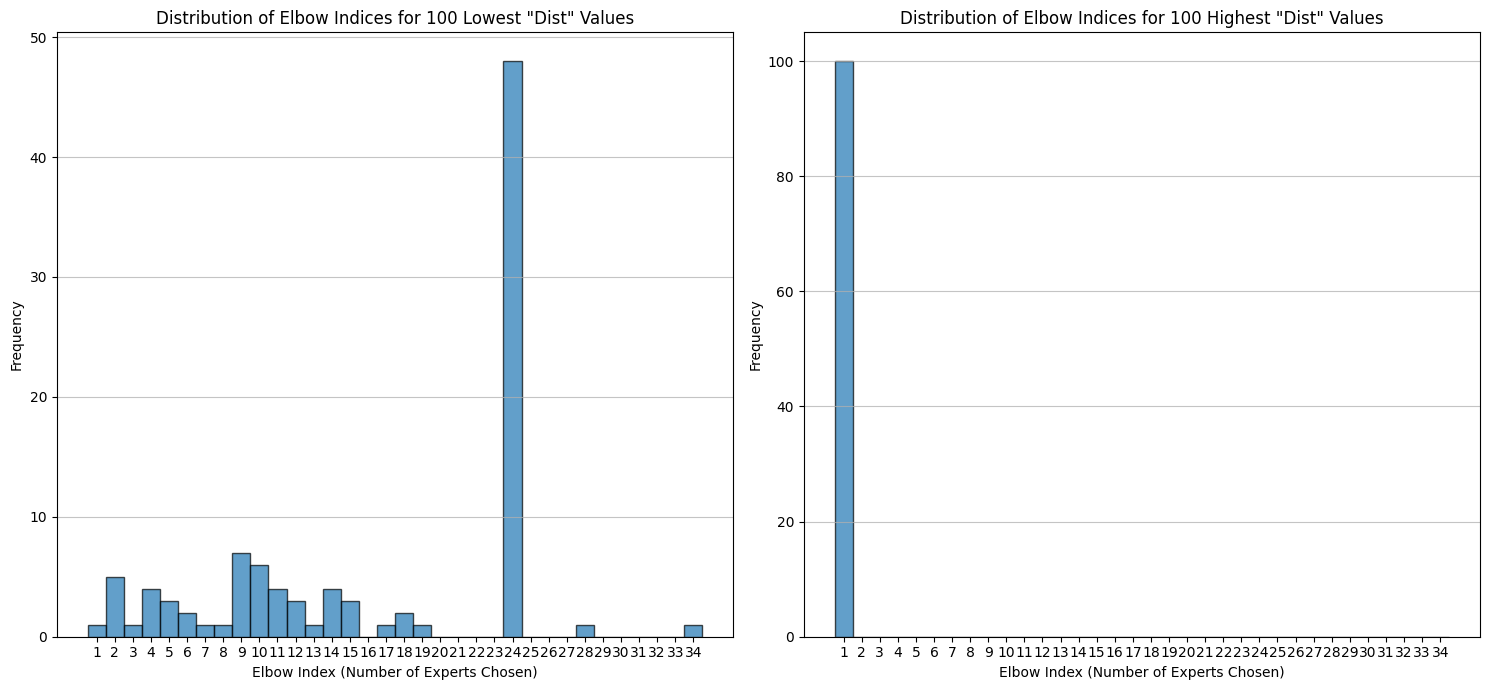

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Reconstruct a list of (dist_value, global_index) tuples
all_dist_values_with_indices = []
current_global_idx = 0
num_vectors_per_layer = None

for layer_idx in sorted(elbow_results_by_layer.keys()):
    dist_values_for_layer = elbow_results_by_layer[layer_idx]['dist_values']

    if num_vectors_per_layer is None:
        num_vectors_per_layer = len(dist_values_for_layer)

    for i, dist_val in enumerate(dist_values_for_layer):
        all_dist_values_with_indices.append((dist_val, current_global_idx))
        current_global_idx += 1

# Sort by dist_value
sorted_dist_values = sorted(all_dist_values_with_indices, key=lambda x: x[0])

# Get the 100 lowest and 100 highest dist values
lowest_dist_samples = sorted_dist_values[:100]
highest_dist_samples = sorted_dist_values[-100:]

# Extract elbow indices for these samples
lowest_elbow_indices = []
for dist_val, global_idx in lowest_dist_samples:
    layer_idx = global_idx // num_vectors_per_layer
    row_idx = global_idx % num_vectors_per_layer
    lowest_elbow_indices.append(elbow_results_by_layer[layer_idx]['idx_values'][row_idx])

highest_elbow_indices = []
for dist_val, global_idx in highest_dist_samples:
    layer_idx = global_idx // num_vectors_per_layer
    row_idx = global_idx % num_vectors_per_layer
    highest_elbow_indices.append(elbow_results_by_layer[layer_idx]['idx_values'][row_idx])

# Determine common bins for histograms
all_indices = lowest_elbow_indices + highest_elbow_indices
min_idx = min(all_indices) if all_indices else 0
max_idx = max(all_indices) if all_indices else 64 # Max possible expert count
bins = np.arange(min_idx, max_idx + 2) - 0.5 # Center bins on integer values

plt.figure(figsize=(15, 7))

# Histogram for lowest dist values' elbow indices
plt.subplot(1, 2, 1)
plt.hist(lowest_elbow_indices, bins=bins, edgecolor='black', alpha=0.7)
plt.title('Distribution of Elbow Indices for 100 Lowest "Dist" Values')
plt.xlabel('Elbow Index (Number of Experts Chosen)')
plt.ylabel('Frequency')
plt.xticks(np.arange(min_idx, max_idx + 1))
plt.grid(axis='y', alpha=0.75)

# Histogram for highest dist values' elbow indices
plt.subplot(1, 2, 2)
plt.hist(highest_elbow_indices, bins=bins, edgecolor='black', alpha=0.7)
plt.title('Distribution of Elbow Indices for 100 Highest "Dist" Values')
plt.xlabel('Elbow Index (Number of Experts Chosen)')
plt.ylabel('Frequency')
plt.xticks(np.arange(min_idx, max_idx + 1))
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [5]:
import pickle

arceasy_output_file = '/content/drive/MyDrive/arceasy_router_logits.pkl'

with open(arceasy_output_file, 'rb') as f:
    arceasy = pickle.load(f)


arcchallenge_output_file = '/content/drive/MyDrive/arcchallenge_router_logits.pkl'

with open(arcchallenge_output_file, 'rb') as f:
    arcchallenge = pickle.load(f)

In [6]:
import numpy as np
import torch

# Define helpers locally to ensure they handle the numpy format efficiently
def calculate_original_elbow_np(y_np):
    if len(y_np) < 2: return 0
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 0
    y_normalized = (y_np[0] - y_np) / y_range
    diff = y_normalized - x_norm
    return int(np.argmax(diff))

def elbow_angle_np(y_np, elbowidx):
    if elbowidx == 0 or elbowidx == len(y_np) - 1: return 180.0
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 180.0
    y_norm = (y_np[0] - y_np) / y_range

    pe = np.array([x_norm[elbowidx], y_norm[elbowidx]])
    ps = np.array([0.0, 0.0])
    pend = np.array([1.0, 1.0])
    v1 = ps - pe
    v2 = pend - pe
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

def analyze_dataset_logits(dataset_data, name):
    print(f"Processing {name}...")
    all_indices = []
    all_angles = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Iterate through all samples
    for sample_idx, routers in dataset_data['router_logits'].items():
        # Iterate through all layers/routers for this sample
        for router_name, logits in routers.items():
            # Ensure we have a tensor on the right device
            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits)
            logits = logits.to(device).float()

            # 1. Softmax
            probs = torch.softmax(logits, dim=-1)

            # 2. Sort Descending
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)

            # Move to CPU numpy for element-wise processing
            sorted_probs_np = sorted_probs.cpu().numpy()

            # 3. Calculate Elbow stats for each row
            for row in sorted_probs_np:
                idx = calculate_original_elbow_np(row)
                ang = elbow_angle_np(row, idx)

                all_indices.append(idx)
                all_angles.append(ang)

    print(f"  Finished {name}: {len(all_indices)} logits.")
    print(f"  Mean Elbow Index: {np.mean(all_indices):.4f}")
    print(f"  Mean Elbow Angle: {np.mean(all_angles):.4f} degrees\n")
    return all_indices, all_angles

# Run analysis
print("Starting analysis on ARC datasets...\n")
arceasy_indices, arceasy_angles = analyze_dataset_logits(arceasy, "ARC Easy")
arcchallenge_indices, arcchallenge_angles = analyze_dataset_logits(arcchallenge, "ARC Challenge")

Starting analysis on ARC datasets...

Processing ARC Easy...
  Finished ARC Easy: 456192 logits.
  Mean Elbow Index: 9.6029
  Mean Elbow Angle: 115.5720 degrees

Processing ARC Challenge...
  Finished ARC Challenge: 533184 logits.
  Mean Elbow Index: 9.6176
  Mean Elbow Angle: 115.6805 degrees



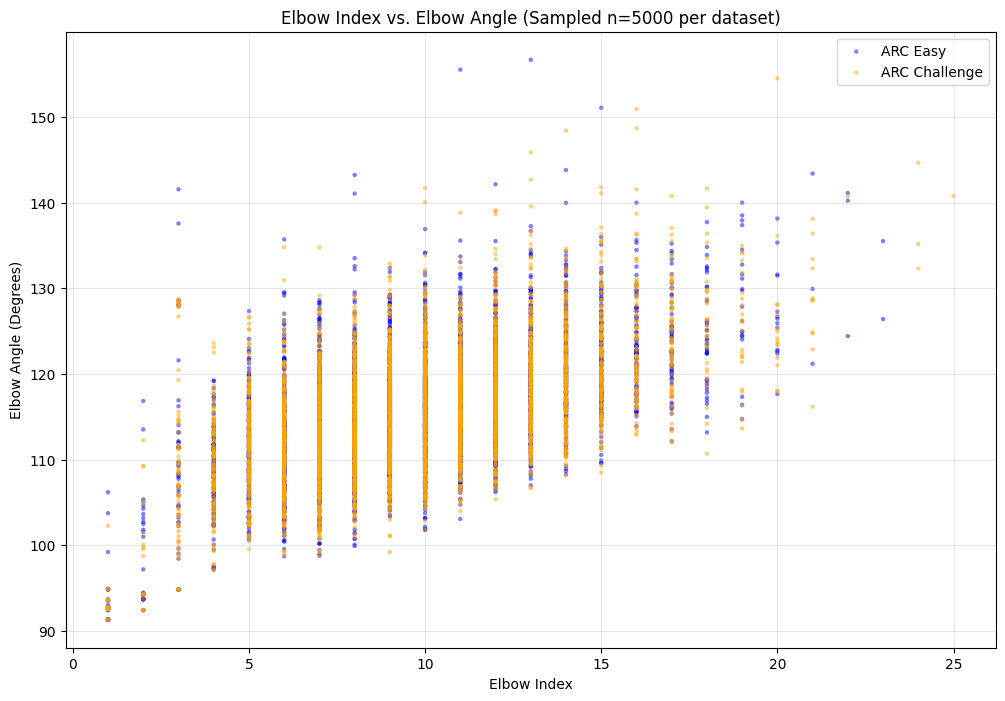

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Number of points to sample per dataset for clarity
num_samples = 5000

# Function to sample indices
def sample_data(indices, angles, n):
    total = len(indices)
    if total < n:
        return indices, angles

    # Generate random indices
    sample_idxs = np.random.choice(total, n, replace=False)

    # Use list comprehension or numpy indexing depending on type (vars show they are lists)
    # Converting to numpy array for easy indexing
    return np.array(indices)[sample_idxs], np.array(angles)[sample_idxs]

# Sample the data
easy_x, easy_y = sample_data(arceasy_indices, arceasy_angles, num_samples)
chal_x, chal_y = sample_data(arcchallenge_indices, arcchallenge_angles, num_samples)

plt.figure(figsize=(12, 8))

# Plot ARC Easy
plt.scatter(easy_x, easy_y,
            alpha=0.5,
            s=10,
            label='ARC Easy',
            color='blue',
            edgecolors='none')

# Plot ARC Challenge
plt.scatter(chal_x, chal_y,
            alpha=0.5,
            s=10,
            label='ARC Challenge',
            color='orange',
            edgecolors='none')

plt.title(f'Elbow Index vs. Elbow Angle (Sampled n={num_samples} per dataset)')
plt.xlabel('Elbow Index')
plt.ylabel('Elbow Angle (Degrees)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Searching for samples with Elbow Angle > 155 degrees...

==================== Example 1 (ARC Easy) ====================
Layer: model.layers.15.mlp.gate | Elbow Angle: 163.88° | Elbow Idx: 24
Question:
For the reaction between silver nitrate and sodium chloride, which of the following would be a product? AgNo_{3} + NaCl ->
(A) AgNa
(B) ClNO_{3}
(C) Na_{3}NO
(D) AgCl

==================== Example 2 (ARC Easy) ====================
Layer: model.layers.7.mlp.gate | Elbow Angle: 155.85° | Elbow Idx: 12
Question:
If Earth revolved at a faster rate, what would most likely occur?
(A) Annual rainfall would increase.
(B) Daylight hours would decrease.
(C) Seasons would be shorter.
(D) Annual temperature variation would be greater.

==================== Example 3 (ARC Easy) ====================
Layer: model.layers.15.mlp.gate | Elbow Angle: 161.00° | Elbow Idx: 9
Question:
To study the effect of heat on plant growth, Andy divided ten identical seedlings into groups. She placed one group on a windo

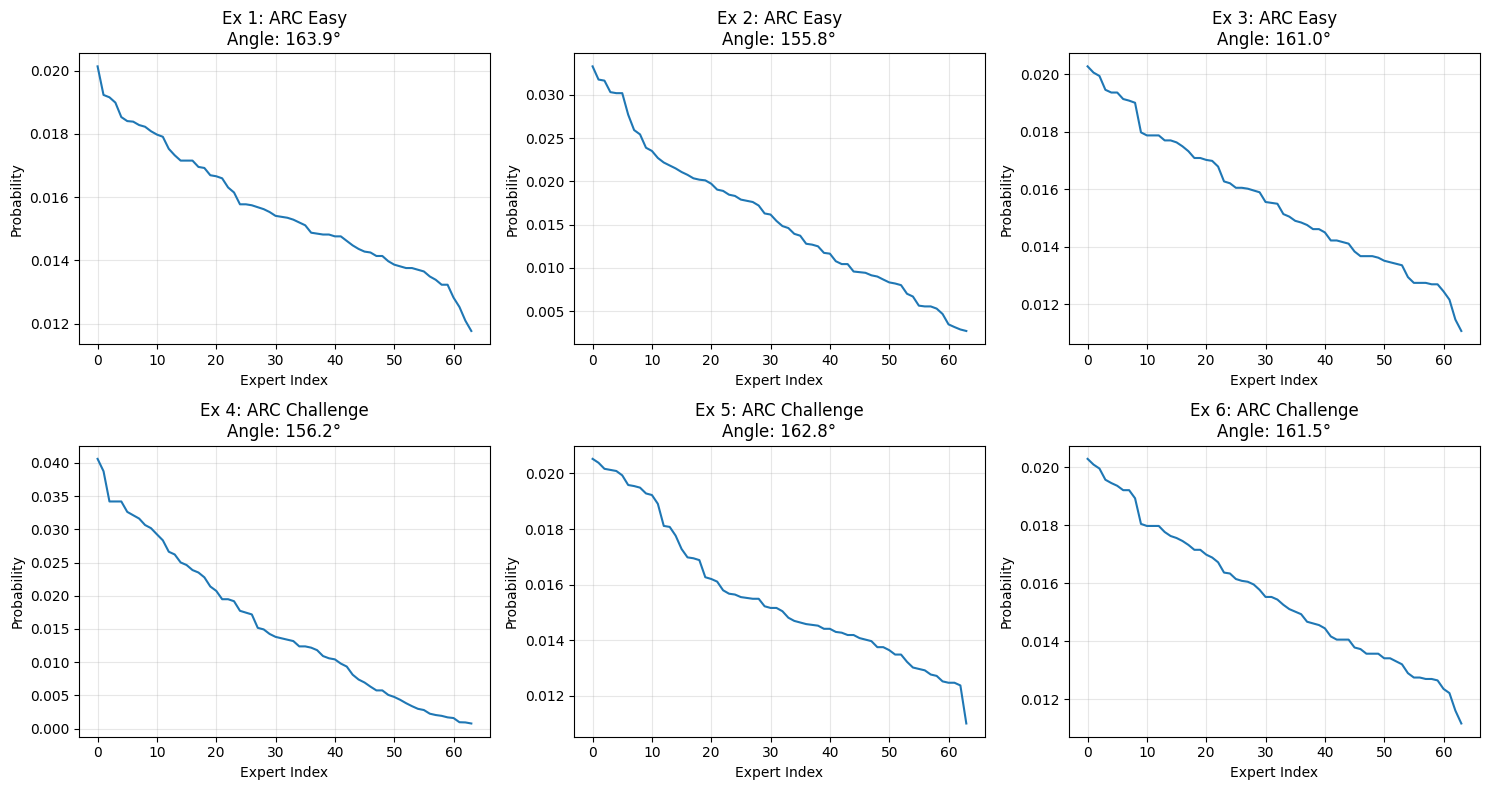

In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure helper functions are available
# (relying on calculate_original_elbow_np and elbow_angle_np from previous cells)

def find_high_angle_samples(dataset_data, dataset_name, threshold=155, num_examples=3):
    found_samples = []
    count = 0

    # Iterate samples
    for sample_idx, sample_data in enumerate(dataset_data['samples']):
        if count >= num_examples: break

        logits_dict = dataset_data['router_logits'][sample_idx]

        # iterate layers/logits
        for router_name, logits in logits_dict.items():
            if count >= num_examples: break

            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits)

            # Process logits (Softmax + Sort)
            probs = torch.softmax(logits.float(), dim=-1)
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)
            sorted_probs_np = sorted_probs.cpu().numpy()

            # Check each token's logit
            # We'll just check the first few tokens to avoid excessive loop time,
            # or check all if efficient enough. Checking all for robustness.
            for row_idx, row in enumerate(sorted_probs_np):
                idx = calculate_original_elbow_np(row)
                angle = elbow_angle_np(row, idx)

                if angle > threshold:
                    # Found one!
                    q_text = dataset_data['samples'][sample_idx]['question']
                    choices = dataset_data['samples'][sample_idx]['choices']

                    # Format choices nicely
                    formatted_choices = "\n".join([f"({l}) {t}" for l, t in zip(choices['label'], choices['text'])])
                    formatted_q = f"{q_text}\n{formatted_choices}"

                    found_samples.append({
                        'question': formatted_q,
                        'logit': row,
                        'angle': angle,
                        'layer': router_name,
                        'dataset': dataset_name,
                        'elbow_idx': idx
                    })
                    count += 1
                    break # Move to next sample to avoid duplicate questions
    return found_samples

# Find samples
print("Searching for samples with Elbow Angle > 155 degrees...")
high_angle_samples = []
high_angle_samples.extend(find_high_angle_samples(arceasy, "ARC Easy", threshold=155))
high_angle_samples.extend(find_high_angle_samples(arcchallenge, "ARC Challenge", threshold=155))

# Print Questions
for i, sample in enumerate(high_angle_samples):
    print(f"\n{'='*20} Example {i+1} ({sample['dataset']}) {'='*20}")
    print(f"Layer: {sample['layer']} | Elbow Angle: {sample['angle']:.2f}° | Elbow Idx: {sample['elbow_idx']}")
    print(f"Question:\n{sample['question']}")

# Plot Logits
if high_angle_samples:
    rows = (len(high_angle_samples) + 2) // 3
    plt.figure(figsize=(15, 4 * rows))
    for i, sample in enumerate(high_angle_samples):
        plt.subplot(rows, 3, i+1)
        plt.plot(sample['logit'])
        plt.title(f"Ex {i+1}: {sample['dataset']}\nAngle: {sample['angle']:.1f}°")
        plt.xlabel("Expert Index")
        plt.ylabel("Probability")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No samples found with that threshold.")

Extracting (layer, angle) pairs for ARC Easy...
Extracting (layer, angle) pairs for ARC Challenge...


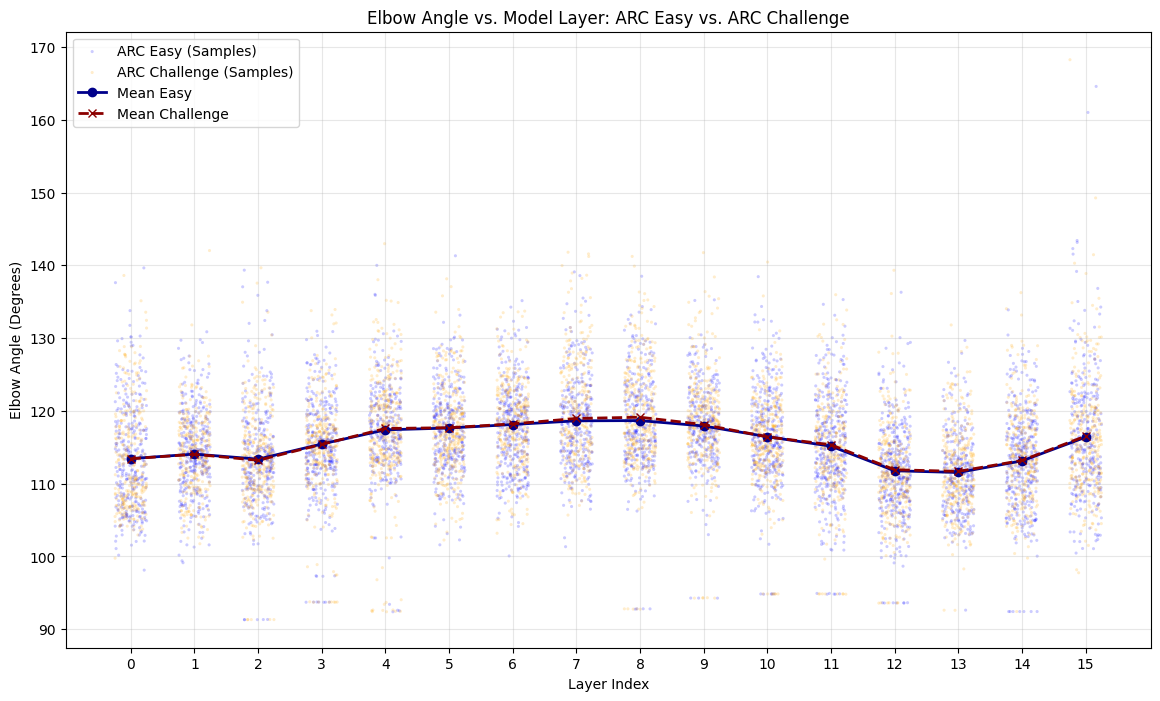

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import re

# Ensure helper functions are defined locally for safety
def calculate_original_elbow_np(y_np):
    if len(y_np) < 2: return 0
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 0
    y_normalized = (y_np[0] - y_np) / y_range
    diff = y_normalized - x_norm
    return int(np.argmax(diff))

def elbow_angle_np(y_np, elbowidx):
    if elbowidx == 0 or elbowidx == len(y_np) - 1: return 180.0
    x_norm = np.linspace(0, 1, len(y_np))
    y_range = y_np[0] - y_np[-1]
    if y_range == 0: return 180.0
    y_norm = (y_np[0] - y_np) / y_range

    pe = np.array([x_norm[elbowidx], y_norm[elbowidx]])
    ps = np.array([0.0, 0.0])
    pend = np.array([1.0, 1.0])
    v1 = ps - pe
    v2 = pend - pe
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

def get_layer_angles(dataset_data, name):
    print(f"Extracting (layer, angle) pairs for {name}...")
    layer_angle_pairs = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for sample_idx, routers in dataset_data['router_logits'].items():
        for router_name, logits in routers.items():
            # Extract layer index from string "model.layers.X.mlp.gate"
            match = re.search(r'layers\.(\d+)\.', router_name)
            if not match: continue
            layer_idx = int(match.group(1))

            # Convert to tensor/numpy
            if not isinstance(logits, torch.Tensor):
                logits = torch.tensor(logits)

            # Softmax and Sort
            probs = torch.softmax(logits.float().to(device), dim=-1)
            sorted_probs, _ = torch.sort(probs, descending=True, dim=-1)
            sorted_probs_np = sorted_probs.cpu().numpy()

            # Calc angles
            for row in sorted_probs_np:
                idx = calculate_original_elbow_np(row)
                angle = elbow_angle_np(row, idx)
                layer_angle_pairs.append((layer_idx, angle))

    return layer_angle_pairs

# Extract data
easy_data = get_layer_angles(arceasy, "ARC Easy")
chal_data = get_layer_angles(arcchallenge, "ARC Challenge")

# Function to sample and separate x/y
def prepare_plot_data(data_pairs, n_samples=5000):
    if len(data_pairs) > n_samples:
        sampled = random.sample(data_pairs, n_samples)
    else:
        sampled = data_pairs

    x = np.array([p[0] for p in sampled])
    y = np.array([p[1] for p in sampled])

    # Add jitter to x
    jitter = np.random.uniform(-0.25, 0.25, size=len(x))
    return x + jitter, y

# Prepare for plotting
easy_x, easy_y = prepare_plot_data(easy_data)
chal_x, chal_y = prepare_plot_data(chal_data)

# Calculate Means per layer
def get_layer_means(data_pairs):
    layer_sums = {i: [] for i in range(16)}
    for l, ang in data_pairs:
        if 0 <= l < 16:
            layer_sums[l].append(ang)
    return [np.mean(layer_sums[i]) for i in range(16)]

easy_means = get_layer_means(easy_data)
chal_means = get_layer_means(chal_data)

# Plot
plt.figure(figsize=(14, 8))

# Scatter Points
plt.scatter(easy_x, easy_y, s=5, alpha=0.2, color='blue', label='ARC Easy (Samples)', edgecolors='none')
plt.scatter(chal_x, chal_y, s=5, alpha=0.2, color='orange', label='ARC Challenge (Samples)', edgecolors='none')

# Mean Lines
plt.plot(range(16), easy_means, color='darkblue', marker='o', linewidth=2, label='Mean Easy')
plt.plot(range(16), chal_means, color='darkred', marker='x', linewidth=2, linestyle='--', label='Mean Challenge')

plt.title('Elbow Angle vs. Model Layer: ARC Easy vs. ARC Challenge')
plt.xlabel('Layer Index')
plt.ylabel('Elbow Angle (Degrees)')
plt.xticks(range(16))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

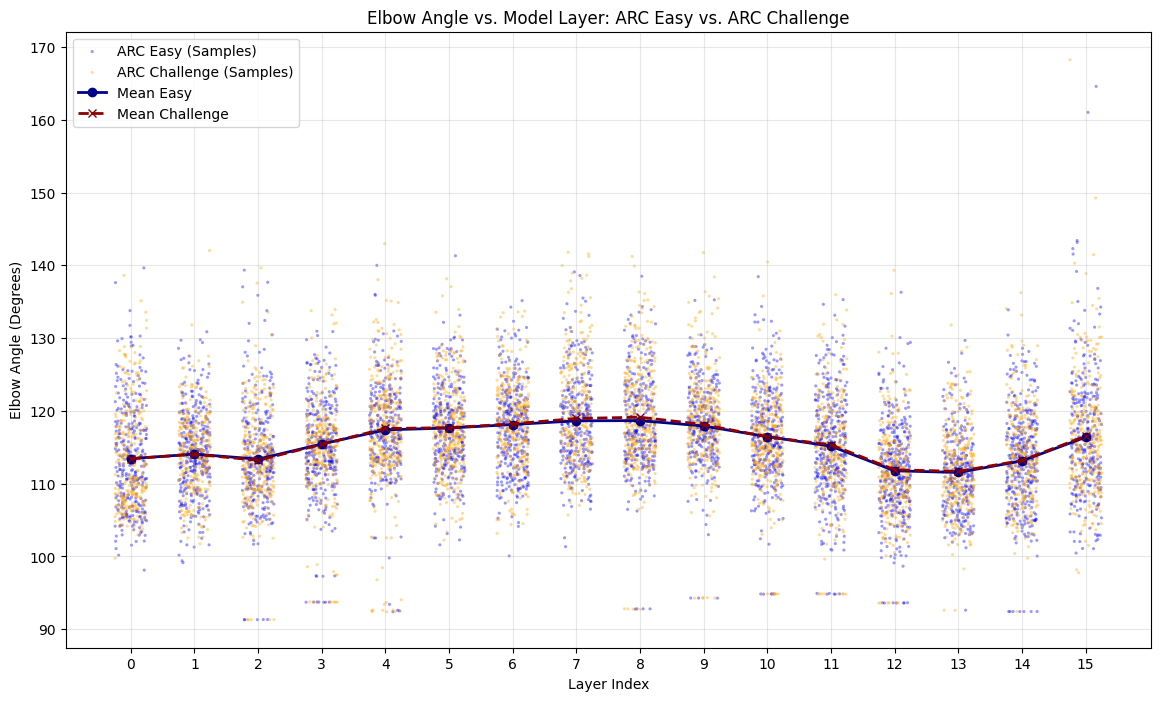

In [13]:
# Plot
plt.figure(figsize=(14, 8))

# Scatter Points
plt.scatter(easy_x, easy_y, s=5, alpha=0.4, color='blue', label='ARC Easy (Samples)', edgecolors='none')
plt.scatter(chal_x, chal_y, s=5, alpha=0.4, color='orange', label='ARC Challenge (Samples)', edgecolors='none')

# Mean Lines
plt.plot(range(16), easy_means, color='darkblue', marker='o', linewidth=2, label='Mean Easy')
plt.plot(range(16), chal_means, color='darkred', marker='x', linewidth=2, linestyle='--', label='Mean Challenge')

plt.title('Elbow Angle vs. Model Layer: ARC Easy vs. ARC Challenge')
plt.xlabel('Layer Index')
plt.ylabel('Elbow Angle (Degrees)')
plt.xticks(range(16))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

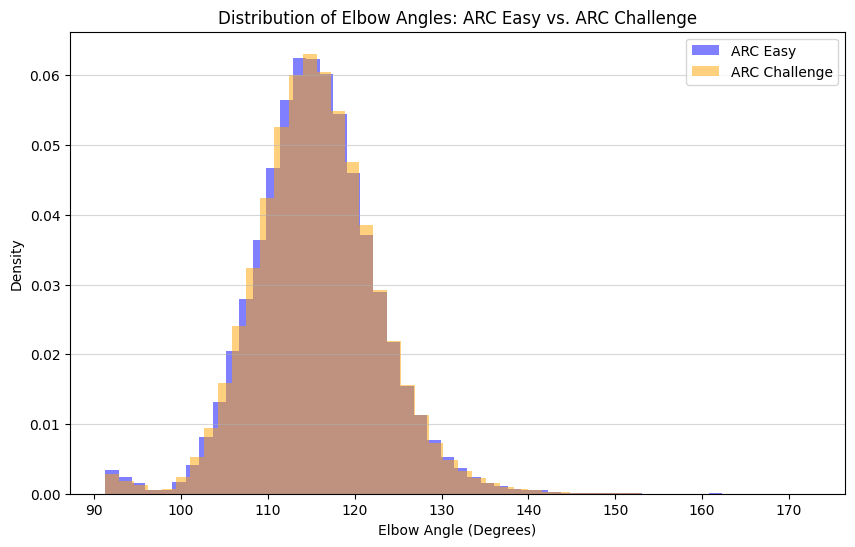

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot ARC Easy Histogram
plt.hist(arceasy_angles, bins=50, alpha=0.5, label='ARC Easy', color='blue', density=True)

# Plot ARC Challenge Histogram
plt.hist(arcchallenge_angles, bins=50, alpha=0.5, label='ARC Challenge', color='orange', density=True)

plt.title('Distribution of Elbow Angles: ARC Easy vs. ARC Challenge')
plt.xlabel('Elbow Angle (Degrees)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

Sampled Logits Analysis:
Sample 1: Layer 10, Row 85190 -> Elbow Index: 12, Dist (diff[elbowidx]): 0.6279
Sample 2: Layer 14, Row 104694 -> Elbow Index: 10, Dist (diff[elbowidx]): 0.5919
Sample 3: Layer 12, Row 23161 -> Elbow Index: 16, Dist (diff[elbowidx]): 0.6067
Sample 4: Layer 11, Row 75632 -> Elbow Index: 11, Dist (diff[elbowidx]): 0.5107
Sample 5: Layer 3, Row 18124 -> Elbow Index: 10, Dist (diff[elbowidx]): 0.5270
Sample 6: Layer 14, Row 97363 -> Elbow Index: 10, Dist (diff[elbowidx]): 0.6730
Sample 7: Layer 8, Row 81164 -> Elbow Index: 12, Dist (diff[elbowidx]): 0.6067
Sample 8: Layer 11, Row 9287 -> Elbow Index: 12, Dist (diff[elbowidx]): 0.5928
Sample 9: Layer 4, Row 84976 -> Elbow Index: 8, Dist (diff[elbowidx]): 0.5250
Sample 10: Layer 7, Row 26514 -> Elbow Index: 8, Dist (diff[elbowidx]): 0.6918
Sample 11: Layer 9, Row 55583 -> Elbow Index: 8, Dist (diff[elbowidx]): 0.6313
Sample 12: Layer 3, Row 66534 -> Elbow Index: 11, Dist (diff[elbowidx]): 0.6970
Sample 13: Layer 13, 

/tmp/ipython-input-98870453.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = (y[0] - y) / y_range - x_norm


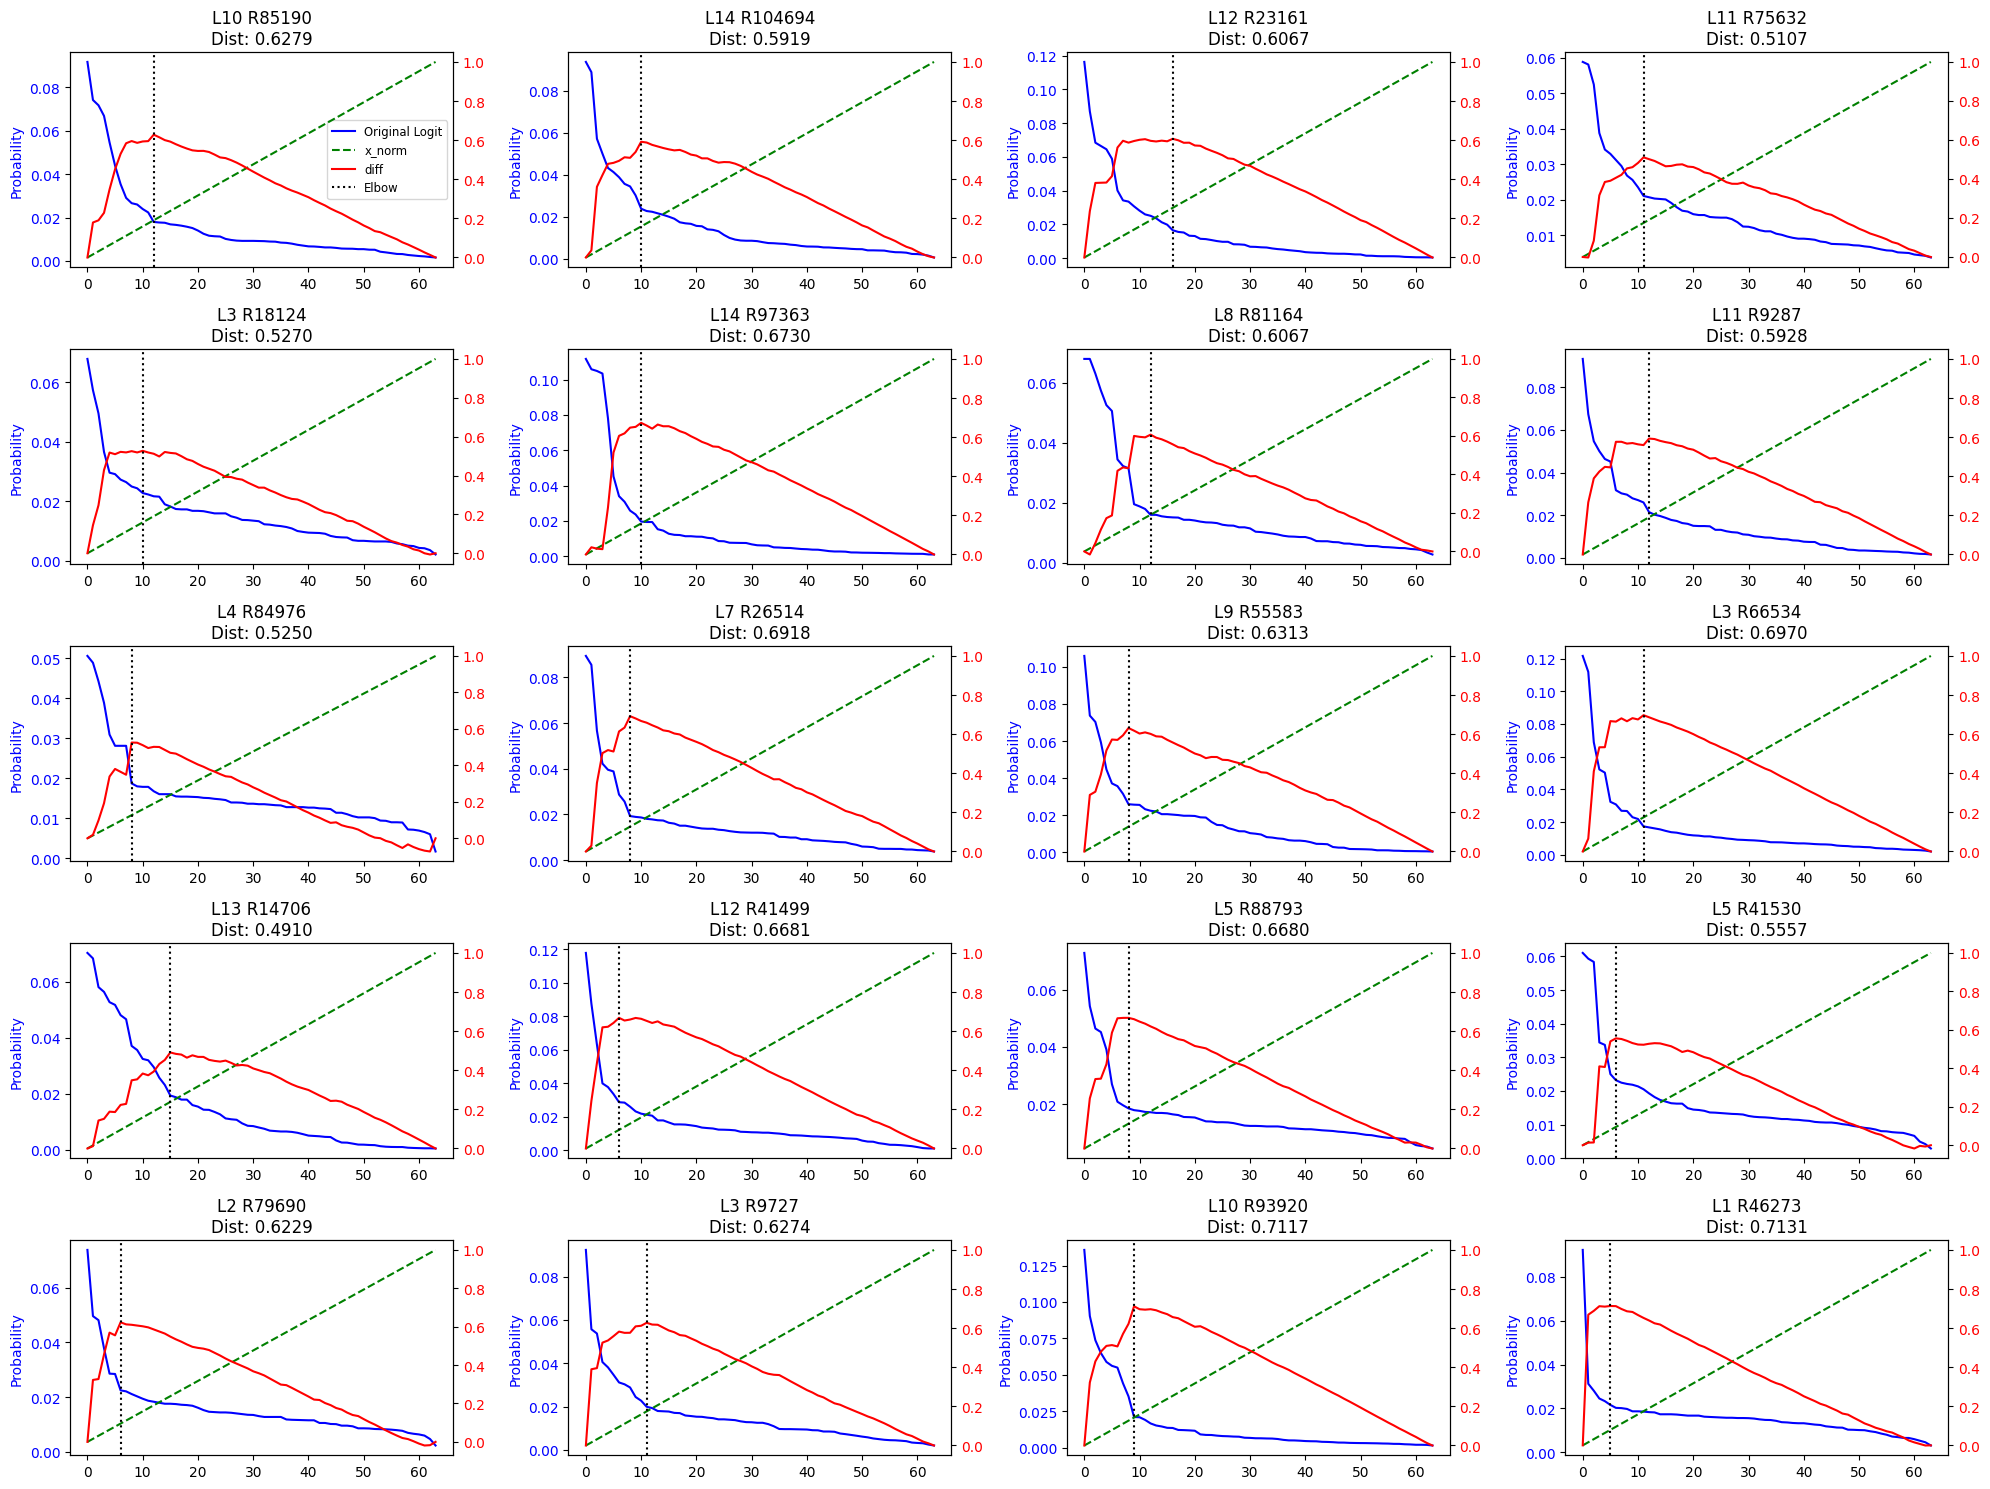

In [30]:
## EXTRA: insight on how kneedle works - red line is difference between green and normalized blue line

import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get list of layers
layers = list(all_logits_by_layer.keys())

# Create figure
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

print("Sampled Logits Analysis:")

for i in range(20):
    # Randomly sample a layer and a row
    layer = random.choice(layers)
    n_rows = all_logits_by_layer[layer].shape[0]
    row_idx = random.randint(0, n_rows - 1)

    # Get the logit data
    y_np = all_logits_by_layer[layer][row_idx]
    y_tensor = torch.from_numpy(y_np).float()

    # Calculate using the original elbow function
    elbowidx, dist_val = calculate_original_elbow(y_tensor)
    print(f"Sample {i+1}: Layer {layer}, Row {row_idx} -> Elbow Index: {elbowidx}, Dist (diff[elbowidx]): {dist_val:.4f}")

    # Reconstruct variables for plotting
    # (Replicating logic from calculate_original_elbow)
    x_norm = torch.arange(len(y_tensor), dtype=torch.float32) / (len(y_tensor) - 1)
    y_range = y_tensor[0] - y_tensor[-1]
    normalized_y = (y_tensor[0] - y_tensor) / y_range
    diff = normalized_y - x_norm

    # Plot
    ax = axes[i]

    # Plot original logit on primary y-axis
    l1, = ax.plot(y_np, label='Original Logit', color='blue')
    ax.set_ylabel('Probability', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot x_norm and diff on secondary y-axis
    ax2 = ax.twinx()
    l2, = ax2.plot(x_norm.numpy(), label='x_norm', color='green', linestyle='--')
    l3, = ax2.plot(diff.numpy(), label='diff', color='red')
    l4 = ax2.axvline(x=elbowidx, color='black', linestyle=':', label='Elbow')
    ax2.tick_params(axis='y', labelcolor='red')

    ax.set_title(f"L{layer} R{row_idx}\nDist: {dist_val:.4f}")

    # Legend for the first plot only to avoid clutter
    if i == 0:
        lines = [l1, l2, l3, l4]
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc='center right', fontsize='small')

plt.tight_layout()
plt.show()